In [1]:
%matplotlib inline

## [Gaussian Mixtures](https://scikit-learn.org/stable/modules/mixture.html)
- GMMs are probabilistic models that assume all data is generated from a set of Gaussian distributions *with unknown parameters*.
- Uses [expectation maximization (EM)](https://scikit-learn.org/stable/modules/mixture.html#expectation-maximization) to fit the models.
- Can draw confidence ellipsoids for multivariate models
- Can use the Bayesian Info Criterion (BIC) to find the number of clusters in a dataset.

## Example
- plot predicted labels for training & test data with multiple GMM covariance types.
- Compared: spherical, diagonal, full & tied covariance matrices
- Full covariance = prone to overfitting on small datasets
- Training data = "."; test data = "x".
- Iris dataset = 4-dimensional - only first 2 dimensions shown, so some data is separated in other dimensions.

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt

import numpy as np

from sklearn import datasets
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import StratifiedKFold

In [6]:
colors = ['navy', 'turquoise', 'darkorange']

def make_ellipses(gmm, ax):
    for n, color in enumerate(colors):
        if gmm.covariance_type == 'full':
            covariances = gmm.covariances_[n][:2, :2]
        elif gmm.covariance_type == 'tied':
            covariances = gmm.covariances_[:2, :2]
        elif gmm.covariance_type == 'diag':
            covariances = np.diag(gmm.covariances_[n][:2])
        elif gmm.covariance_type == 'spherical':
            covariances = np.eye(gmm.means_.shape[1]) * gmm.covariances_[n]

        v, w  = np.linalg.eigh(covariances)
        u     = w[0] / np.linalg.norm(w[0])
        angle = np.arctan2(u[1], u[0])
        angle = 180 * angle / np.pi  # convert to degrees
        v     = 2. * np.sqrt(2.) * np.sqrt(v)
        ell   = mpl.patches.Ellipse(gmm.means_[n, :2], 
                                    v[0], v[1],
                                    180 + angle, 
                                    color=color)
        ell.set_clip_box(ax.bbox)
        ell.set_alpha(0.5)
        ax.add_artist(ell)
        ax.set_aspect('equal', 'datalim')

iris = datasets.load_iris()

# Break into non-overlapping training (75%) and testing (25%) sets.
skf = StratifiedKFold(n_splits=4)
# Only take the first fold.
train_index, test_index = next(iter(skf.split(iris.data, iris.target)))
X_train                 = iris.data[train_index]
y_train                 = iris.target[train_index]
X_test                  = iris.data[test_index]
y_test                  = iris.target[test_index]
n_classes               = len(np.unique(y_train))

# Try GMMs using different types of covariances.
estimators = {cov_type: GaussianMixture(n_components    = n_classes,
                                        covariance_type = cov_type, 
                                        max_iter        = 20, 
                                        random_state    = 0)
              for cov_type in ['spherical', 'diag', 'tied', 'full']}

n_estimators = len(estimators)

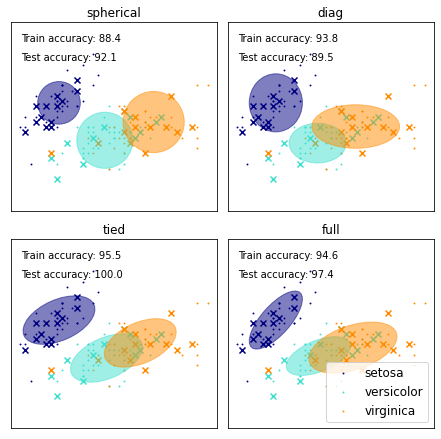

In [7]:
plt.figure(figsize=(3 * n_estimators // 2, 6))
plt.subplots_adjust(bottom=.01, top=0.95, hspace=.15, wspace=.05,
                    left=.01, right=.99)

# Since we have class labels for the training data, we can
# initialize the GMM parameters in a supervised manner.
for index, (name, estimator) in enumerate(estimators.items()):
    estimator.means_init = np.array([X_train[y_train == i].mean(axis=0)
                                    for i in range(n_classes)])

    # Train the other parameters using the EM algorithm.
    estimator.fit(X_train)

    h = plt.subplot(2, n_estimators // 2, index + 1)
    make_ellipses(estimator, h)

    for n, color in enumerate(colors):
        data = iris.data[iris.target == n]
        plt.scatter(data[:, 0], data[:, 1], s=0.8, color=color,
                    label=iris.target_names[n])
    # Plot the test data with crosses
    for n, color in enumerate(colors):
        data = X_test[y_test == n]
        plt.scatter(data[:, 0], data[:, 1], marker='x', color=color)

    y_train_pred = estimator.predict(X_train)
    train_accuracy = np.mean(y_train_pred.ravel() == y_train.ravel()) * 100
    plt.text(0.05, 0.9, 'Train accuracy: %.1f' % train_accuracy,
             transform=h.transAxes)

    y_test_pred = estimator.predict(X_test)
    test_accuracy = np.mean(y_test_pred.ravel() == y_test.ravel()) * 100
    plt.text(0.05, 0.8, 'Test accuracy: %.1f' % test_accuracy,
             transform=h.transAxes)

    plt.xticks(())
    plt.yticks(())
    plt.title(name)

plt.legend(scatterpoints=1, loc='lower right', prop=dict(size=12))
plt.show()

## Example: Model Selection using GMMs
- variants to consider: 1) covariance type, 2) number of model components

In [8]:
import numpy as np
import itertools
from scipy import linalg
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn import mixture

In [9]:
n_samples = 500

# Generate random sample, two components
np.random.seed(0)
C                  = np.array([[0., -0.1], 
                               [1.7, .4]])
X                  = np.r_[np.dot(np.random.randn(n_samples, 2), C),
                           0.7 * np.random.randn(n_samples, 2) + np.array([-6, 3])]
lowest_bic         = np.infty
bic                = []
n_components_range = range(1, 7)
cv_types           = ['spherical', 'tied', 'diag', 'full']

In [10]:
for cv_type in cv_types:
    for n_components in n_components_range:
        gmm = mixture.GaussianMixture(n_components    = n_components,
                                      covariance_type = cv_type)
        gmm.fit(X)
        bic.append(gmm.bic(X))
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm   = gmm

bic        = np.array(bic)
color_iter = itertools.cycle(['navy', 'turquoise', 'cornflowerblue', 'darkorange'])
clf        = best_gmm
bars       = []

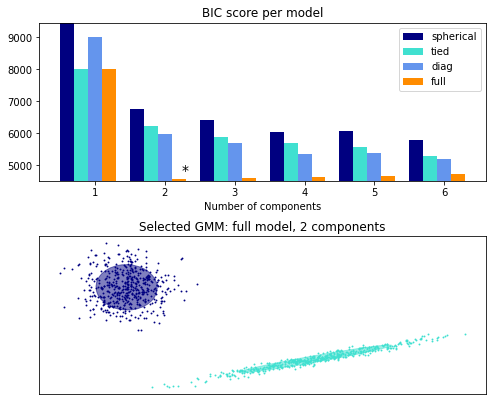

In [11]:
# Plot the BIC scores
plt.figure(figsize=(8, 6))
spl = plt.subplot(2, 1, 1)

for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
    xpos = np.array(n_components_range) + .2 * (i - 2)
    bars.append(plt.bar(xpos, bic[i * len(n_components_range):
                                  (i + 1) * len(n_components_range)],
                        width=.2, 
                        color=color))
    
plt.xticks(n_components_range)
plt.ylim([bic.min() * 1.01 - .01 * bic.max(), bic.max()])
plt.title('BIC score per model')

xpos = np.mod(bic.argmin(), 
              len(n_components_range)) + .65 +\
              0.2 * np.floor(bic.argmin() / len(n_components_range))

plt.text(xpos, 
         bic.min() * 0.97 + .03 * bic.max(), 
         '*', 
         fontsize=14)

spl.set_xlabel('Number of components')
spl.legend([b[0] for b in bars], cv_types)

# Plot the winner
splot = plt.subplot(2, 1, 2)
Y_    = clf.predict(X)

for i, (mean, cov, color) in enumerate(zip(clf.means_, clf.covariances_,
                                           color_iter)):
    v, w = linalg.eigh(cov)
    if not np.any(Y_ == i):
        continue
    plt.scatter(X[Y_ == i, 0], X[Y_ == i, 1], .8, color=color)

    # Plot an ellipse to show the Gaussian component
    angle = np.arctan2(w[0][1], w[0][0])
    angle = 180. * angle / np.pi  # convert to degrees
    v     = 2. * np.sqrt(2.) * np.sqrt(v)
    ell   = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=color)
    ell.set_clip_box(splot.bbox)
    ell.set_alpha(.5)
    splot.add_artist(ell)

plt.xticks(())
plt.yticks(())
plt.title('Selected GMM: full model, 2 components')
plt.subplots_adjust(hspace=.35, bottom=.02)
plt.show()

## Expectation-Maximization (EM)
- GMM's main problem is that you normally don't know which points came from which latent component.
- EM is an iterative algorithm that first assumes random components & finds, for each data point, a probability of having been generated by each component. The next iteration tweaks the params to maximize the likelihood of the data given those assignments. Repeating this process will always converge to a local optimum.

## Variational Bayesian GMMs
- Variational Inference: an extension of EM; it adds a regularization component by integrating results from previous distributions. Usually slower, but not fatally so.
- Needs more parameters than EM; the most important being ```weight_concentration_prior```. Low values force the model to put more weight on a few components; high values allow large number of components to be active.
- Below: Results from different weight concentration priors.

In [12]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from sklearn.mixture import BayesianGaussianMixture

In [13]:
def plot_ellipses(ax, weights, means, covars):
    for n in range(means.shape[0]):
        eig_vals, eig_vecs = np.linalg.eigh(covars[n])
        unit_eig_vec = eig_vecs[0] / np.linalg.norm(eig_vecs[0])
        angle = np.arctan2(unit_eig_vec[1], unit_eig_vec[0])
        # Ellipse needs degrees
        angle = 180 * angle / np.pi
        # eigenvector normalization
        eig_vals = 2 * np.sqrt(2) * np.sqrt(eig_vals)
        ell = mpl.patches.Ellipse(means[n], eig_vals[0], eig_vals[1],
                                  180 + angle, edgecolor='black')
        ell.set_clip_box(ax.bbox)
        ell.set_alpha(weights[n])
        ell.set_facecolor('#56B4E9')
        ax.add_artist(ell)


def plot_results(ax1, ax2, estimator, X, y, title, plot_title=False):
    ax1.set_title(title)
    ax1.scatter(X[:, 0], X[:, 1], s=5, marker='o', color=colors[y], alpha=0.8)
    ax1.set_xlim(-2., 2.)
    ax1.set_ylim(-3., 3.)
    ax1.set_xticks(())
    ax1.set_yticks(())
    plot_ellipses(ax1, estimator.weights_, estimator.means_,
                  estimator.covariances_)

    ax2.get_xaxis().set_tick_params(direction='out')
    ax2.yaxis.grid(True, alpha=0.7)
    for k, w in enumerate(estimator.weights_):
        ax2.bar(k, w, width=0.9, color='#56B4E9', zorder=3,
                align='center', edgecolor='black')
        ax2.text(k, w + 0.007, "%.1f%%" % (w * 100.),
                 horizontalalignment='center')
    ax2.set_xlim(-.6, 2 * n_components - .4)
    ax2.set_ylim(0., 1.1)
    ax2.tick_params(axis='y', which='both', left=False,
                    right=False, labelleft=False)
    ax2.tick_params(axis='x', which='both', top=False)

    if plot_title:
        ax1.set_ylabel('Estimated Mixtures')
        ax2.set_ylabel('Weight of each component')

In [14]:
# Parameters of the dataset
random_state, n_components, n_features = 2, 3, 2
colors = np.array(['#0072B2', '#F0E442', '#D55E00'])

covars = np.array([[[.7, .0], [.0, .1]],
                   [[.5, .0], [.0, .1]],
                   [[.5, .0], [.0, .1]]])
samples = np.array([200, 500, 200])
means = np.array([[.0, -.70],
                  [.0, .0],
                  [.0, .70]])

In [15]:
# mean_precision_prior= 0.8 to minimize the influence of the prior
estimators = [
    ("Finite mixture with a Dirichlet distribution\nprior and" r"$\gamma_0=$", 
     BayesianGaussianMixture(
         weight_concentration_prior_type = "dirichlet_distribution",
         n_components                    = 2*n_components, 
         reg_covar                       = 0, 
         init_params                     = 'random',
         max_iter                        = 1500, 
         mean_precision_prior            = 0.8,
        random_state                     =random_state), 
     [0.001, 1, 1000]),
    
    ("Infinite mixture with a Dirichlet process\n prior and" r"$\gamma_0=$",
     BayesianGaussianMixture(
        weight_concentration_prior_type = "dirichlet_process",
        n_components                    = 2*n_components, 
        reg_covar                       = 0, 
        init_params                     = 'random',
        max_iter                        = 1500, 
        mean_precision_prior            = 0.8,
        random_state                    =random_state), 
     [1, 1000, 100000])]

# Generate data
rng = np.random.RandomState(random_state)
X   = np.vstack([rng.multivariate_normal(means[j], 
                                         covars[j], 
                                         samples[j])
    for j in range(n_components)])

y   = np.concatenate([np.full(samples[j], 
                              j, 
                              dtype=int)
                    for j in range(n_components)])

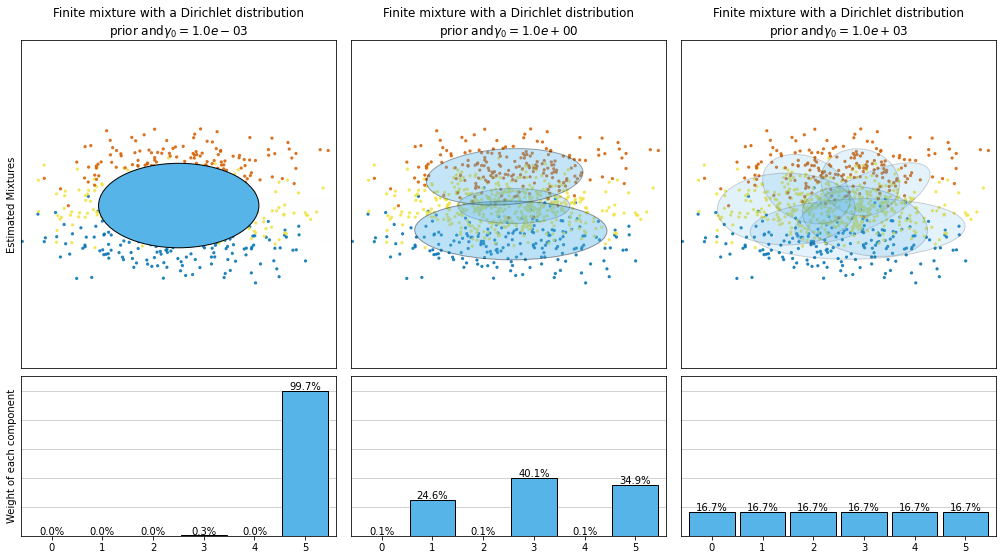

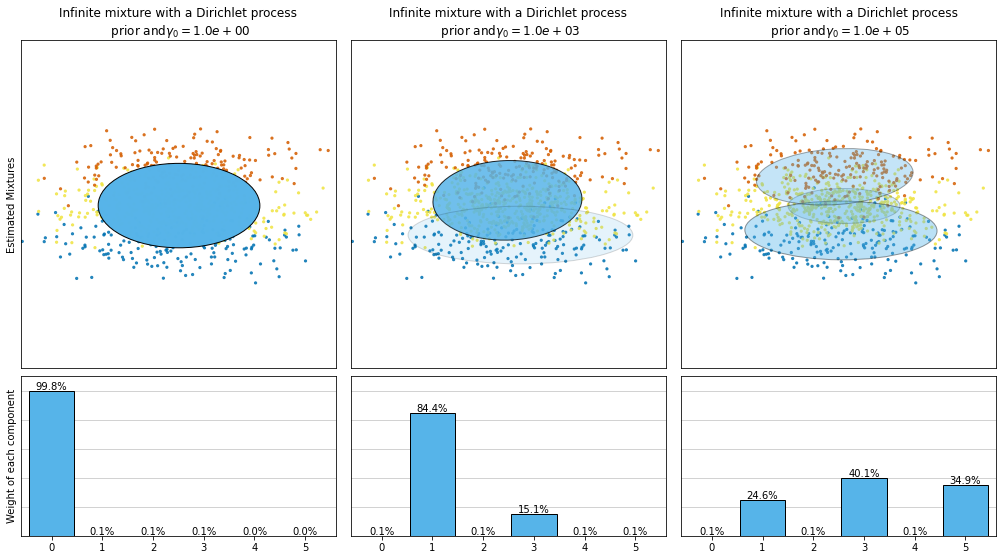

In [16]:
for (title, estimator, concentrations_prior) in estimators:
    plt.figure(figsize=(4.7 * 3, 8))
    plt.subplots_adjust(bottom=.04, top=0.90, hspace=.05, wspace=.05,
                        left=.03, right=.99)

    gs = gridspec.GridSpec(3, len(concentrations_prior))
    for k, concentration in enumerate(concentrations_prior):
        estimator.weight_concentration_prior = concentration
        estimator.fit(X)
        plot_results(plt.subplot(gs[0:2, k]), 
                     plt.subplot(gs[2, k]), 
                     estimator,
                     X, y, r"%s$%.1e$" % (title, concentration),
                     plot_title=k == 0)

plt.show()